# ECE 143: Programming for Data Analysis 

## Petfinder.my Adoption Prediction 
*Predicting the adoptability of pets based on different features*

- Initial Analysis
- State-wise Count and HDI (Combining States)
- Average Adoption rate per State
- Recommender System
    
__Inderjot Saggu__

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os.path
from os import path
import matplotlib.pyplot as plt
import difflib

plt.rcParams['figure.figsize'] = (10,6)

In [12]:
# Load the data 

breed_labels = pd.read_csv("../data/breed_labels.csv")
color_labels = pd.read_csv("../data/color_labels.csv")
state_labels = pd.read_csv("../data/state_labels.csv")

# Check if file already exists
if not path.exists('../data/train.csv'):
    train_zip = zipfile.ZipFile('../data/train.zip')
    train_zip.extractall('../data')
    train_zip.close()

train = pd.read_csv("../data/train.csv")


In [13]:
# Initial look at the data
def initial_analysis(data):
    '''
    Presents an overview of the data
    
    Inputs: 
        data: of type Pandas.DataFrame object
    Outputs:
        First 5 data points
        Statistical info of all the features
        Histograms
    '''
    assert isinstance(data, pd.DataFrame)
    print(train.head())
    print(train.describe())
    
    # Histogram plots of the all features 
    %matplotlib inline 
    train.hist(bins=50, figsize=(20,15))
    plt.show()

#initial_analysis(train)

In [14]:
# Creating a copy of data for visualization
train_copy = train.copy()

    StateID        StateName
0     41336            Johor
1     41325            Kedah
2     41367         Kelantan
3     41401     Kuala Lumpur
4     41415           Labuan
5     41324           Melaka
6     41332  Negeri Sembilan
7     41335           Pahang
8     41330            Perak
9     41380           Perlis
10    41327     Pulau Pinang
11    41345            Sabah
12    41342          Sarawak
13    41326         Selangor
14    41361       Terengganu


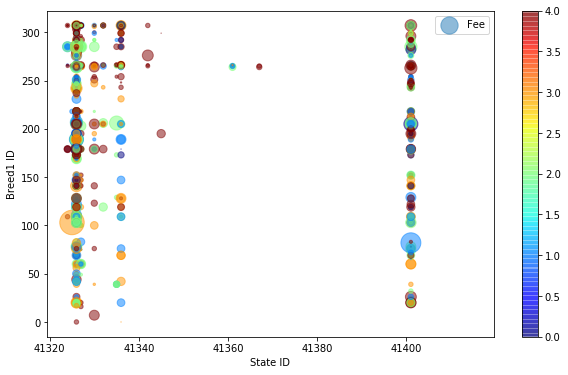

In [15]:
# Data density For each State vs Breed1 
# Area of each point is proportional to Fee
# Color of each point is representative of adoptibility

state_dict = dict(zip(state_labels["StateID"], state_labels["StateName"]))

x_axis = [state_dict[i] for i in train_copy["State"]]
x_axis = pd.DataFrame(x_axis)

train_copy["StateName"] = x_axis
print(state_labels)
sc = plt.scatter(train_copy["State"], train_copy["Breed1"], alpha=0.5, 
            s=train_copy["Fee"]/5, label="Fee", c=train_copy["AdoptionSpeed"],
            cmap=plt.get_cmap("jet"))
plt.colorbar(sc)
plt.xlabel("State ID")
plt.ylabel("Breed1 ID")
plt.legend()

## Correlation Between Different Attributes

In [22]:
corr_matrix = train_copy.corr()
corr_matrix["AdoptionSpeed"]

Type            -0.091540
Age              0.100561
Breed1           0.105304
Breed2          -0.016753
Gender           0.057481
Color1          -0.041201
Color2          -0.037847
Color3          -0.008227
MaturitySize     0.044836
FurLength       -0.094169
Vaccinated      -0.065154
Dewormed        -0.016800
Sterilized      -0.092401
Health           0.028697
Quantity         0.063949
Fee             -0.004021
State           -0.035238
VideoAmt         0.000574
PhotoAmt        -0.019677
AdoptionSpeed    1.000000
Name: AdoptionSpeed, dtype: float64

## State-HDI Analysis

In [18]:
# Correlating top states with HDI 
state_labels['HDI'] = [0.785, 0.769, 0.741, 0.822, 
                       0.742, 0.794, 0.789, 0.766, 
                       0.778, 0.767, 0.803, 0.674, 
                       .707, 0.819, 0.762]

# Idenify Top States
top_states = train_copy['State'].value_counts()
x = []
y = []
bar_color = []
for state in top_states.index:
    x.append(state_dict[state])
    y.append(top_states[state])
    bar_color.append(state_labels.loc[state_labels['StateID'] == state]['HDI'].values[0])
    print(state_dict[state], state_labels.loc[state_labels['StateID'] == state]['HDI'].values[0])

Selangor 0.819
Kuala Lumpur 0.822
Pulau Pinang 0.803
Johor 0.785
Perak 0.778
Negeri Sembilan 0.789
Melaka 0.794
Kedah 0.769
Pahang 0.766
Terengganu 0.762
Sabah 0.674
Kelantan 0.741
Sarawak 0.707
Labuan 0.742


0.539193190475


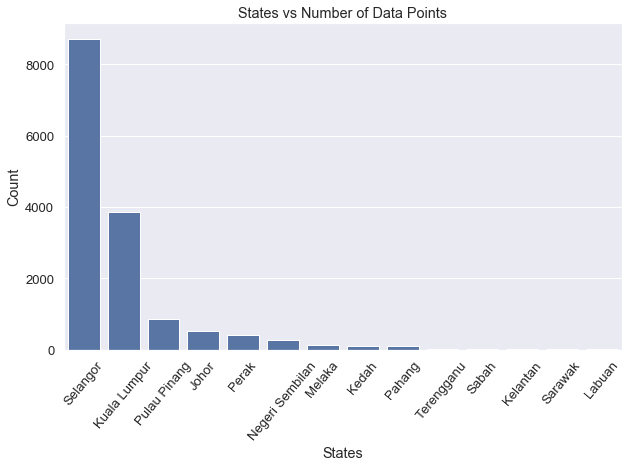

In [23]:
sns.set(font_scale=1.2)

my_plot = sns.barplot(x, y, color = 'b')
for item in my_plot.get_xticklabels():
    item.set_rotation(50)
    
plt.xlabel("States")
plt.ylabel("Count")
plt.title("States vs Number of Data Points")
# Correlation between count and HDI
print(np.corrcoef(y, bar_color)[0,1])

In [20]:
# Combine 
    # Johor 0.785
    # Perak 0.778
    # Negeri Sembilan 0.789
    # Melaka 0.794 as one state

train_copy = train_copy.replace(to_replace = [41336, 41330, 41332], value = 0)

## Average Adoption Speed per State

[2.4520312141381684, 2.5401820546163849, 2.7817319098457887, 2.6499999999999999]


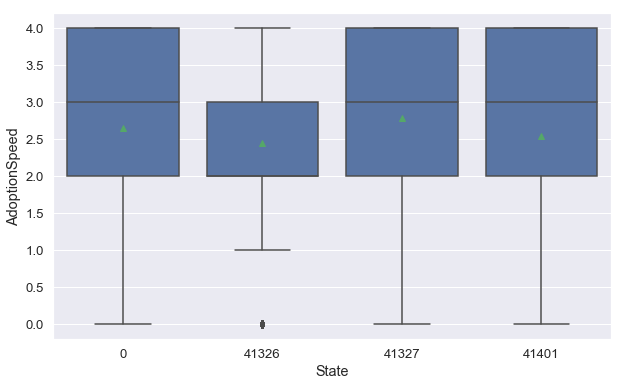

In [21]:
top_state_ID = [41326, 41401, 41327, 0]
top_states_name = ['Selangor', 'Kuala Lumpur', 'Pulau Pinang', 'Combined_state']
average_adoption_speed = []

train_copy= train_copy.drop(train_copy[(train_copy['State'] != 41326) & (train_copy['State'] != 41401)
                          & (train_copy['State'] != 41327)& (train_copy['State'] != 0)].index)

sns.boxplot(x = train_copy['State'], y=train_copy["AdoptionSpeed"], showmeans=True , color = 'b')

for i in range(len(top_state_ID)):
    average_adoption_speed.append(train_copy.loc[train_copy['State'] == top_state_ID[i]]['AdoptionSpeed'].mean(0))


print(average_adoption_speed)


## Recommender System

In [17]:
breed_dict = dict(zip(breed_labels['BreedName'].values, breed_labels['BreedID'].values))

def recommender_system():
    '''
    A simple recommender for pet adoption!!!
    
    User Inputs: 
        Name of the state
        Type of Pet {dog OR cat}
        Breed of the Pet
        
    Output:
        Top 5 Pet Profiles that fit the input information-
        -based on higher chances of adoptability
    '''
    
    state = input("Enter State: ")
    pet_type = input("Type of Pet: ")
    pet_breed = input("Breed: ")
    
    inv_state_dict = {v: k for k, v in state_dict.items()}
    
    state = difflib.get_close_matches(state, inv_state_dict.keys(), n=1, cutoff=0)[0]

    if state not in inv_state_dict:
        print("Enter a valid State, Thank you!")
        return 
    else:
        stateID = inv_state_dict[state]
        
    if pet_type.lower() =='dog':
        pet_type = 1
    elif pet_type.lower() =='cat':
        pet_type = 2
    else:
        print("Enter a valid Pet Type, we only have cats and dogs, Thank you!")
    
    pet_breed = difflib.get_close_matches(pet_breed, breed_dict.keys(), n=1, cutoff=0)[0]
    
    if pet_breed not in breed_dict:
        print("Enter a valid breed, Thank you")
        return
    else:
        pet_breed = breed_dict[pet_breed]
    
    pet_data = train_copy[(train_copy['State'] == stateID) & (train_copy['Breed1'] == pet_breed) & (train_copy['Type'] == pet_type)]
    pet_data = pet_data.sort_values(by=['AdoptionSpeed'])
    
    pet_data = pet_data.drop(['State', 'Color1', 'Color2', 'Color3', 'Breed1', 'Breed2', 
                              'RescuerID', 'PhotoAmt', 'VideoAmt', 'AdoptionSpeed',
                             'MaturitySize', 'Health'], axis =1)
    
    pet_data['Vaccinated'] = pet_data['Vaccinated'].map({1:'Yes', 2:'No', 3:'Not Sure'})
    pet_data['Dewormed'] = pet_data['Dewormed'].map({1:'Yes', 2:'No', 3:'Not Sure'})
    pet_data['Sterilized'] = pet_data['Sterilized'].map({1:'Yes', 2:'No', 3:'Not Sure'})

    
    return pet_data.head()
    
        
recommender_system()


Enter State: Selangor
Type of Pet: Cat
Breed: Domestic


,Type,Name,Age,Gender,FurLength,Vaccinated,Dewormed,Sterilized,Quantity,Fee,Description,PetID,StateName
4077,2,B,4,1,3,No,Yes,No,1,0,This is Black aka B. He is 4-5months approxima...,6708ff204,Selangor
1896,2,Lulu,6,2,3,Yes,Yes,No,1,100,Lovely playful female. So sad to let her go. W...,8b8c686ec,Selangor
11918,2,1 Month Old Long Hair Kitten,1,2,3,No,No,No,1,0,1 month old long hair kitten looking for a lov...,50af81612,Selangor
10703,2,Rey,12,1,3,Not Sure,Not Sure,Not Sure,1,0,Si notty,977104c05,Selangor
5049,2,Shaila's Long Hair Calico,2,2,3,No,Yes,No,1,50,Adorable domestic long hair kitten looking for...,056bb97e4,Selangor
